### Replicate 2 samples have increased number of minor variants

In [69]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)
library(readr)
library(VennDiagram)

In [70]:
project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV'
mva_folder <- glue("{project_folder}/compare_callers/202204")
output_folder <- glue("{mva_folder}/062322_output")
code <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/code/SARS-CoV-2_analysis'

In [4]:
source(glue("{code}/cov_aalist.R"))
source(glue("{code}/repsnv.R"))
source(glue("{code}/snv_filter.R"))
source(glue("{code}/vennsD.R"))
source(glue("{code}/common.R"))
source(glue("{code}/aasnplist_load.R"))
source(glue("{code}/getminorvariants.R"))
source(glue("{code}/cov_aalist.R"))

In [5]:
tool_colors <- c('#CC2F42', # freebayes - red
                 '#35B6E9', # hc - bright blue
                 '#009E73', # ivar - green
                 '#F9BECD', # lofreq - pink
                 '#F0E442', # mutect2 - yellow
                 '#CCD2EB', # timo - light purple
                 '#8DA1E2', # timo-no-binom - darker purple
                 '#9B9E9A', # varscan - grey
                 '#555555') # varscan, custom1 - darker grey
cat_colors <- c('#2F142B', # TP - dark purple
                '#F2A07B', # FP - peach
                '#5A7A96') # FN - blue
cov_af_colors <- c('#DDDDDD', # 100X - lightest grey
                '#BBBBBB', # 200X
                '#999999', # 300X
                '#777777', # 500X
                '#555555', # 1000X
                '#333333', # 10000X
                '#111111') # 100000X - darkest grey
virus_colors <- c('#2F142B', # H1N1 - dark purple
                  '#F2A07B', # H3N2 - peach
                  '#43668B', # VICT - blue
                  '#8DA1E2') # SARS - light purple

In [9]:
SEGMENTS = c('SARS-CoV2')
# Here we set the coverage cutoff to 5 for identification of consensus changes and the coverage cutoff to 200 for
# identification of minority variants
covcutoff = 5
minorcov = 200
# The initial allele frequency is set to .5%
minfreq = 0.001
# we exclude any instances were an 'N' is called in these analyses
ntlist = c('A','G','T','C')
orf1 <- c('nsp1','nsp2','nsp3','nsp4','nsp5',
          'nsp6','nsp7','nsp8','nsp9','nsp10',
          'nsp11','nsp12a','nsp12b','nsp13',
          'nsp14','nsp15','nsp16')

In [10]:
# load in metadata for samples with high coverage - used for this analysis
highcov <- read.csv(glue("{mva_folder}/highcov.samples.csv"))

In [11]:
# load in VCF files for all samples - generated with vcf_load notebook
vcf.all <- read.csv(file = glue("{project_folder}/compare.callers.vcfs.csv"))

In [56]:
# extract minor changes
# fill data frame with all changes with variant frequency > 3% and less than 50%
covcutoff = 200
afcutoff = 0.001

min.changes <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'standard' &
                                  !tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes.fb <- vcf.all %>% filter(refnt %in% ntlist &
                                  varnt %in% ntlist &
                                  varfreq >= afcutoff &
                                  varfreq < 0.5 &
                                  param == 'custom' &
                                  tool == 'freebayes' &
                                  totalcount >= covcutoff)

min.changes <- rbind(min.changes, min.changes.fb)

min.changes$change <- paste0(min.changes$refnt,min.changes$ntpos,min.changes$varnt)
min.changes$sample.change <- paste0(min.changes$source_ID,":",min.changes$change)
min.changes$rep.change <- paste0(min.changes$rep,"-",min.changes$sample.change)

min.changes <- distinct(min.changes)

min.changes.high <- min.changes %>% filter(source_ID %in% highcov$code)

Of note, we found that replicate 2 data had much higher numbers of minority variants, particularly at very low frequencies, regardless of Ct value or date of sequencing. This suggests that freeze thawing samples may impact minor variant numbers, and reinforces the need for strict cutoffs and replicates during sequencing (Fig. S8A).

In [57]:
counts <- min.changes.high %>% group_by(tool, rep, source_ID) %>% tally()

### Fig. S7C, pt.1

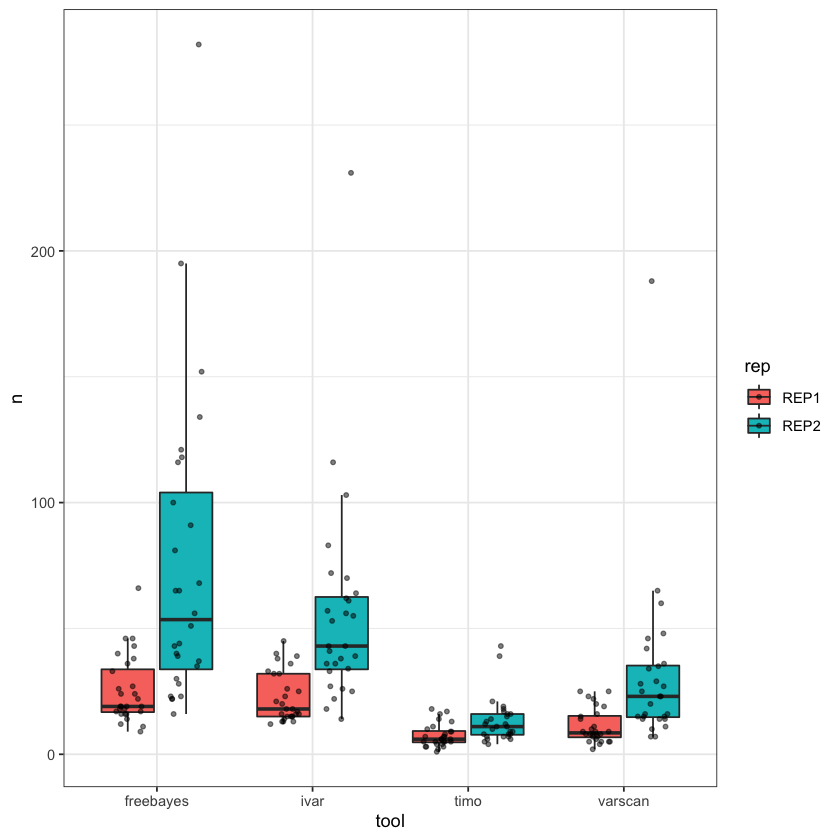

In [72]:
qplot <- ggplot(data = subset(counts, !tool %in% c('haplotypecaller','lofreq','mutect2')),
                              aes(x = tool, y = n, fill = rep)) +

    geom_boxplot(outlier.shape = NA) +

    geom_point(size = 1, alpha = 0.5, position=position_jitterdodge(jitter.width = 0.2)) +

    theme_bw() +

    scale_color_manual(values = cat_colors[c(1,3)])

print(qplot)

### Fig. S7C, pt.2

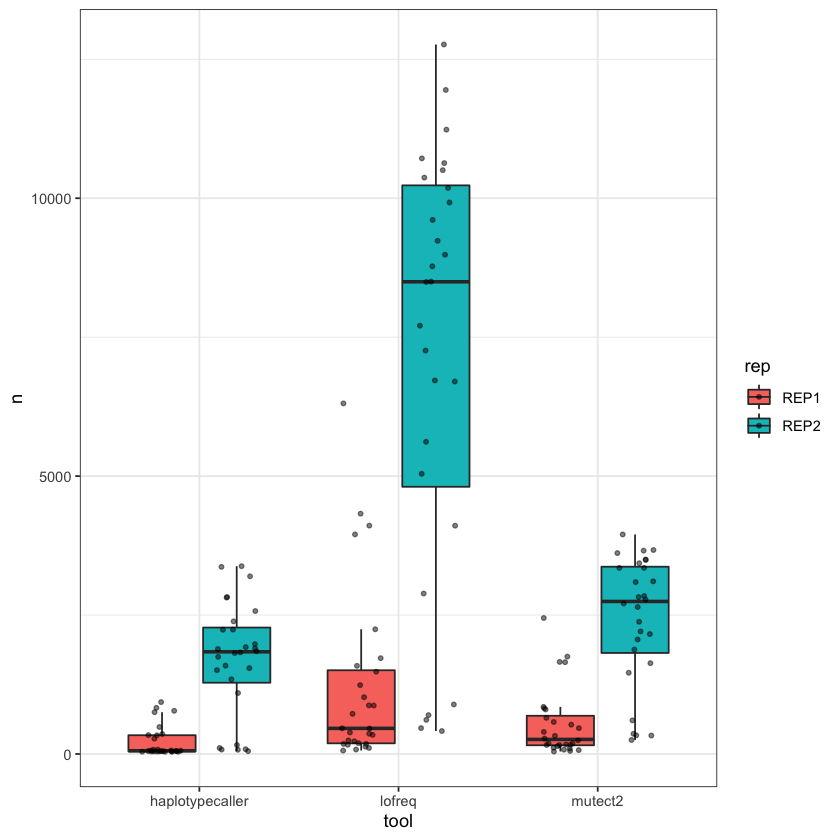

In [73]:
qplot2 <- ggplot(data = subset(counts, tool %in% c('haplotypecaller','lofreq','mutect2')),
                              aes(x = tool, y = n, fill = rep)) +

    geom_boxplot(outlier.shape = NA) +

    geom_point(size = 1, alpha=0.5, position=position_jitterdodge(jitter.width = 0.2)) +

    theme_bw() +

    scale_color_manual(values = cat_colors[c(1,3)])

print(qplot2)

In [74]:
counts2 <- min.changes.high %>% filter(varfreq >= 0.01) %>% group_by(tool, rep, source_ID)  %>% tally()

### Fig. S7C, pt.3

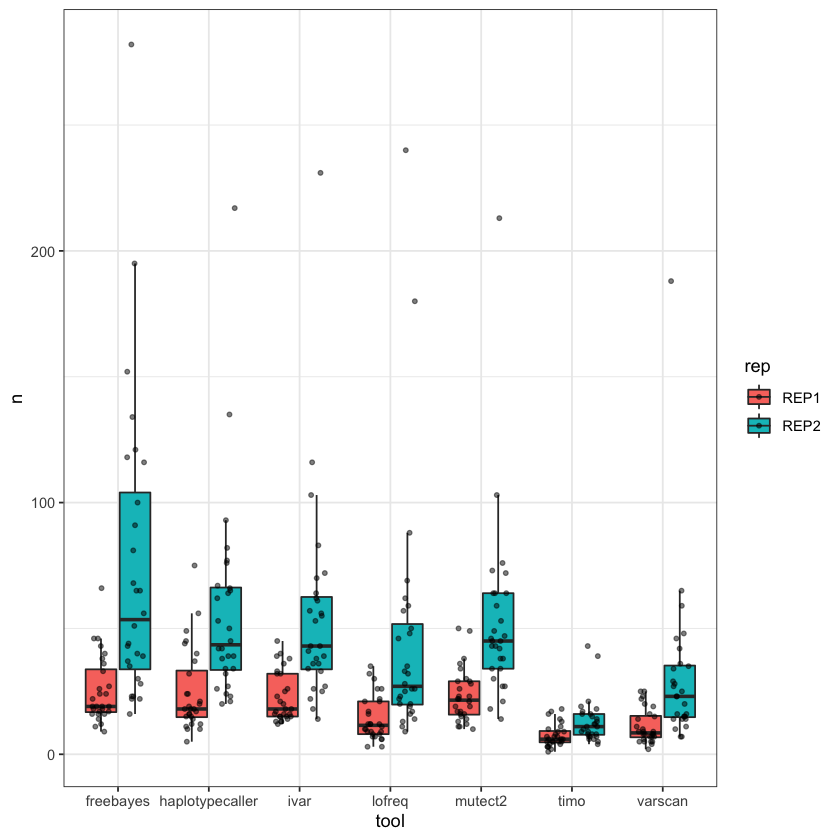

In [75]:
qplot3 <- ggplot(data = counts2, aes(x = tool, y = n, fill = rep)) +

    geom_boxplot(outlier.shape = NA) +

    geom_point(size = 1, alpha = 0.5, position=position_jitterdodge(jitter.width = 0.2)) +

    theme_bw() +

    scale_color_manual(values = cat_colors[c(1,3)])

print(qplot3)

In [76]:
ggsave(qplot, filename = "varnums.0.001.toola.pdf",
    path=output_folder, width = 4, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(qplot2, filename = "varnums.0.001.toolb.pdf",
    path=output_folder, width = 3, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(qplot3, filename = "varnums.0.01.pdf",
    path=output_folder, width = 6, height = 3, limitsize=FALSE, useDingbats =FALSE)